In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from io import StringIO
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
%matplotlib inline

In [22]:
#set random state for replicability
np.random.seed(1234)

In [23]:
def check_file_existence(bucket_name,folder_name,file_name):
    """
    Function checks whether or not a specified file exists in its 
    designated location. Returns True if the file exists, otherwise False. 
    """
    try:
        s3_client = boto3.client('s3')
        s3_client.head_object(Bucket=bucket_name, Key=folder_name + file_name)
        return True
    except:
        return False

def get_file(bucket_name,folder_name,file_name): 
    """
    Function checks whether or not a specified file exists in its 
    designated location. If the file exists, the function retreives it from the 
    designated s3 bucket. 
    """
    if check_file_existence(bucket_name,folder_name,file_name):
        try:
            #get the merged file and save as df
            print('Trying to get object from bucket')
            s3_client = boto3.client('s3')
            file_content = s3_client.get_object(Bucket = bucket_name, Key = folder_name + file_name)['Body'].read().decode('utf-8')
            print('Got file contents from AWS S3')
            file_df = pd.read_csv(StringIO(file_content))
            print('Saved file contents as dataframe')
            return file_df
        except Exception as e:
            return e

In [24]:
bucket_name = 'doc-daily-inmates-in-custody'
folder_name = 'data/merged_files/'
file_name = 'agg_daily_pop.csv'

adp_df = get_file(bucket_name, folder_name, file_name)
adp_df.head()

Trying to get object from bucket
Got file contents from AWS S3
Saved file contents as dataframe


,snapshot_date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,inmate_status_code_CSP,inmate_status_code_DE,inmate_status_code_DEP,inmate_status_code_DNS,inmate_status_code_DPV,inmate_status_code_SCO,inmate_status_code_SSR,Total Population,snapshot_month,snapshot_year
0,2021-07-26,105,3484,9,1648,33,648,295,20,5612,...,11,4456,778,79,264,4,110,5927,7,2021
1,2021-07-27,106,3469,9,1642,31,643,296,18,5586,...,12,4437,771,84,267,4,101,5900,7,2021
2,2021-07-28,106,3478,9,1648,31,640,292,18,5602,...,11,4437,769,84,269,4,110,5912,7,2021
3,2021-07-29,108,3470,9,1649,34,638,291,22,5595,...,10,4436,772,91,264,4,99,5908,7,2021
4,2021-07-30,108,3455,9,1630,33,638,285,21,5567,...,10,4412,761,83,265,4,107,5873,7,2021


In [25]:
adp_df.columns

Index(['snapshot_date', 'race_A', 'race_B', 'race_I', 'race_O', 'race_U',
       'race_W', 'gender_F', 'gender_Gender Unknown', 'gender_M',
       'population_group_Additional Groups', 'population_group_Jail Sentence',
       'population_group_Parole Violation',
       'population_group_Pretrial Detention',
       'population_group_State Prison Sentence: Awaiting Transfer', 'bradh_N',
       'bradh_Y', 'inmate_status_code_CS', 'inmate_status_code_CSP',
       'inmate_status_code_DE', 'inmate_status_code_DEP',
       'inmate_status_code_DNS', 'inmate_status_code_DPV',
       'inmate_status_code_SCO', 'inmate_status_code_SSR', 'Total Population',
       'snapshot_month', 'snapshot_year'],
      dtype='object')

In [26]:
#aggregate to 30 day intervals
#set data type
adp_df['snapshot_date'] = pd.to_datetime(adp_df['snapshot_date'])
#get latest snapshot date
max_date = adp_df['snapshot_date'].max()
#aggregate to 30 day periods
interval_data = adp_df.resample('30D', on='snapshot_date',origin = max_date,closed='right',label = 'right').mean().round().fillna(0).reset_index()
interval_data = interval_data.rename(columns = {'snapshot_date':'End Date','Total Population':'ADP'})
interval_data['Start Date'] = interval_data['End Date'] - pd.to_timedelta(29, unit='D')

#display just date of the start/end date columns localize to specific timezone or altar will assume UTC in graph
interval_data['Start Date'] = interval_data['Start Date'].dt.tz_localize('America/New_York')
interval_data['End Date'] = interval_data['End Date'].dt.tz_localize('America/New_York')

interval_data.head()

,End Date,race_A,race_B,race_I,race_O,race_U,race_W,gender_F,gender_Gender Unknown,gender_M,...,inmate_status_code_DE,inmate_status_code_DEP,inmate_status_code_DNS,inmate_status_code_DPV,inmate_status_code_SCO,inmate_status_code_SSR,ADP,snapshot_month,snapshot_year,Start Date
0,2021-08-02 00:00:00-04:00,107.0,3469.0,9.0,1643.0,32.0,644.0,290.0,20.0,5595.0,...,4436.0,765.0,84.0,268.0,4.0,107.0,5905.0,7.0,2021.0,2021-07-04 00:00:00-04:00
1,2021-09-01 00:00:00-04:00,105.0,3509.0,10.0,1681.0,27.0,645.0,292.0,16.0,5668.0,...,4541.0,754.0,76.0,269.0,3.0,92.0,5977.0,8.0,2021.0,2021-08-03 00:00:00-04:00
2,2021-10-01 00:00:00-04:00,102.0,3492.0,11.0,1684.0,29.0,622.0,289.0,15.0,5637.0,...,4625.0,721.0,60.0,227.0,4.0,102.0,5941.0,9.0,2021.0,2021-09-02 00:00:00-04:00
3,2021-10-31 00:00:00-04:00,92.0,3303.0,12.0,1572.0,24.0,559.0,261.0,13.0,5288.0,...,4562.0,546.0,66.0,149.0,2.0,131.0,5562.0,10.0,2021.0,2021-10-02 00:00:00-04:00
4,2021-11-30 00:00:00-05:00,94.0,3248.0,12.0,1531.0,22.0,527.0,244.0,10.0,5179.0,...,4485.0,485.0,76.0,112.0,2.0,144.0,5433.0,11.0,2021.0,2021-11-01 00:00:00-04:00


In [27]:
#lets only look at the total population
_30day_pop_tot = interval_data[['Start Date','End Date','ADP']]
#add date related regressors
_30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
_30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
#make a binary flag for major us holidays: New Years, Fourth of July, Labor Day, Halloween, Thanksgiving, Christmas/Hanukkah/Kwanzaa
_30day_pop_tot['Holiday'] = _30day_pop_tot['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int)
#add lag term
for i in range(1,13):
    _30day_pop_tot['adp_lag'+str(i)] = _30day_pop_tot['ADP'].shift(i)

#fillnas with zero
_30day_pop_tot = _30day_pop_tot.fillna(0)
_30day_pop_tot.head()

C:\Users\emjoh\AppData\Local\Temp\ipykernel_27580\1159100851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Month'] = _30day_pop_tot['Start Date'].dt.month
C:\Users\emjoh\AppData\Local\Temp\ipykernel_27580\1159100851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _30day_pop_tot['Year'] = _30day_pop_tot['Start Date'].dt.year
C:\Users\emjoh\AppData\Local\Temp\ipykernel_27580\1159100851.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,2021-07-04 00:00:00-04:00,2021-08-02 00:00:00-04:00,5905.0,7,2021,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-08-03 00:00:00-04:00,2021-09-01 00:00:00-04:00,5977.0,8,2021,0,5905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-02 00:00:00-04:00,2021-10-01 00:00:00-04:00,5941.0,9,2021,1,5977.0,5905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-10-02 00:00:00-04:00,2021-10-31 00:00:00-04:00,5562.0,10,2021,1,5941.0,5977.0,5905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-11-01 00:00:00-04:00,2021-11-30 00:00:00-05:00,5433.0,11,2021,1,5562.0,5941.0,5977.0,5905.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
27,2023-09-22 00:00:00-04:00,2023-10-21 00:00:00-04:00,6182.0,9,2023,1,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,5923.0,5946.0,5846.0,5860.0,5911.0,5869.0
28,2023-10-22 00:00:00-04:00,2023-11-20 00:00:00-05:00,6164.0,10,2023,1,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,5923.0,5946.0,5846.0,5860.0,5911.0
29,2023-11-21 00:00:00-05:00,2023-12-20 00:00:00-05:00,6125.0,11,2023,1,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,5923.0,5946.0,5846.0,5860.0
30,2023-12-21 00:00:00-05:00,2024-01-19 00:00:00-05:00,6044.0,12,2023,1,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,5923.0,5946.0,5846.0
31,2024-01-20 00:00:00-05:00,2024-02-18 00:00:00-05:00,6182.0,1,2024,1,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,5923.0,5946.0


In [49]:
#linear regression
#fit the model to the entire dataset and forecast
# Scale the entire dataset
sc = MinMaxScaler()
data = _30day_pop_tot.copy()

data_sc = sc.fit_transform(data.drop(columns=['Start Date', 'End Date']))

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns.to_list()[2:])

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

#train test split
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [50]:
#train and test
# Fit the linear regression model on the entire dataset
model = sm.OLS(y_train, X_train).fit()

# Make in sample predictions
IS_pred = model.predict(X_train)
# Make out of  sample predictions
OS_pred = model.predict(X_test)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     26.51
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           1.29e-05
Time:                        11:59:26   Log-Likelihood:                 45.253
No. Observations:                  25   AIC:                            -58.51
Df Residuals:                       9   BIC:                            -39.00
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month          0.5917      0.107      5.525      0.0

In [51]:
#plot
#inverse scale the model inputs to get IS predicts
IS_inputs = pd.concat([IS_pred,X_train.drop(columns=['const'])],axis = 1)
IS_inputs = IS_inputs.rename(columns={0:'ADP'})
IS_inputs = sc.inverse_transform(IS_inputs)
#do the same with OS data
OS_inputs = pd.concat([OS_pred,X_test.drop(columns=['const'])],axis = 1)
OS_inputs = OS_inputs.rename(columns={0:'ADP'})
OS_inputs = sc.inverse_transform(OS_inputs)

In [52]:
#accuracy in terms of non-scaled values
IS_mse = mean_squared_error(data.iloc[:train_size]['ADP'], IS_inputs[:,0])
IS_mae = mean_absolute_error(data.iloc[:train_size]['ADP'], IS_inputs[:,0])

# Make out of  sample predictions
OS_mse = mean_squared_error(data.iloc[train_size:]['ADP'], OS_inputs[:,0])
OS_mae = mean_absolute_error(data.iloc[train_size:]['ADP'], OS_inputs[:,0])

print(IS_mse, IS_mae)
print(OS_mse, OS_mae)

1000.8312973591464 20.83319644709998
24436.374633956373 123.32029435726314


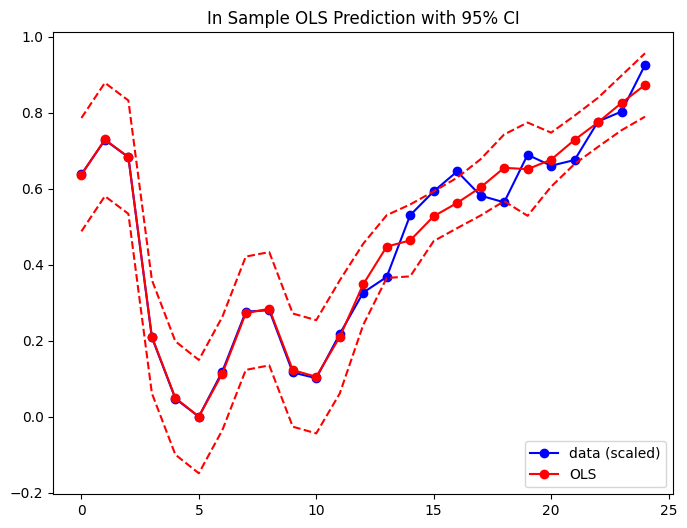

In [66]:
# Get confidence interval for the forecasted value in scaled range
ci_scaled = model.get_prediction(X_train).conf_int(alpha=0.05)

#assaign ADP value in the forecast df
lower_bound = ci_scaled[:,0]
upper_bound = ci_scaled[:,1]


fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(X_train.index, y_train, "bo-", label="data (scaled)")
ax.plot(X_train.index, IS_pred, "ro-", label="OLS")
ax.plot(X_train.index, lower_bound, "r--")
ax.plot(X_train.index, upper_bound, "r--")
ax.legend(loc="best")
plt.title('In Sample OLS Prediction with 95% CI')
plt.show()

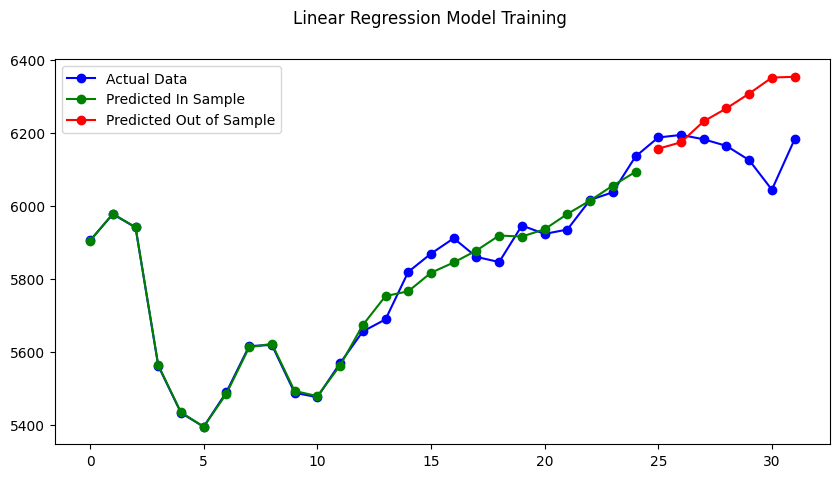

In [67]:
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Linear Regression Model Training')

actual, = plt.plot(data.index,data['ADP'], 'bo-', label='Actual Data')
predicted_IS, = plt.plot(data.iloc[:train_size].index, IS_inputs[:,0], 'go-', label='Predicted In Sample')
predicted_OS, = plt.plot(data.iloc[train_size:].index, OS_inputs[:,0], 'ro-', label='Predicted Out of Sample')

plt.legend(handles=[actual,predicted_IS,predicted_OS])
plt.show()

In [39]:
# Fit the linear regression model on the entire dataset
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     21.24
Date:                Mon, 19 Feb 2024   Prob (F-statistic):           9.16e-08
Time:                        11:47:36   Log-Likelihood:                 40.602
No. Observations:                  32   AIC:                            -49.20
Df Residuals:                      16   BIC:                            -25.75
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Month          0.4065      0.093      4.378      0.0

In [40]:
# Make predictions on the test set
IS_pred = model.predict(X)

#inverse scale the model inputs to get IS predicts
IS_inputs = pd.concat([IS_pred,X.drop(columns=['const'])],axis = 1)
IS_inputs = IS_inputs.rename(columns={0:'ADP'})
IS_inputs = sc.inverse_transform(IS_inputs)

#accuracy in terms of non-scaled values
IS_mse = mean_squared_error(data['ADP'], IS_inputs[:,0])
IS_mae = mean_absolute_error(data['ADP'], IS_inputs[:,0])

print(IS_mse, IS_mae)

2954.9872399877886 37.23455865351164


In [41]:
#now that we fit the model, lets predict 12 timestamps in the future
# Forecast the next 12 months
#last time stamp from data
last_start_date = data['Start Date'].iloc[-1]
forecast_start_dates = pd.Series()

for i in range(2, 15):
    forecast_start_dates.at[i-2] = last_start_date + timedelta(days=30 * i)
# Create a DataFrame for the next 12 months with the same structure as your dataset
forecast_data = pd.DataFrame(columns = data.columns.to_list()[2:])
forecast_data['ADP'] = np.zeros(12) #placeholder for the minmaxscaler

# Fill in other features like Month, Year, and Holiday (adjust as needed)
forecast_data['Month'] = forecast_start_dates.dt.month # Set the month for forecasting
forecast_data['Year'] = forecast_start_dates.dt.year # Set the year for forecasting
forecast_data['Holiday'] = forecast_data['Month'].isin([1, 7, 9, 10, 11, 12]).astype(int) # Set the holiday flag for forecasting

# Fill in the values for lag terms using the actual values from the dataset
# Since the lags are dependent on the ADP IV, we should predict 1 time stamp ahead 12 independent times
# so we can use the previously predicted ADP value in the lag calculation

#since we have all the lag data for the first prediction, we will do this calculation seperately
forecast_data.iloc[0,4:] = data['ADP'].shift(0).iloc[-12:][::-1].reset_index(drop = True)
forecast_data

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12
0,0.0,3,2024,0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,5923.0
1,0.0,4,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,5,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,6,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,7,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,8,2024,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,9,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,10,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,11,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,12,2024,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
#since we have all the lag data for the first prediction, we will do this calculation seperately
# Reshape the one-dimensional array before scaling

#create two empty columns to report the lower and upper ci of forecast
forecast_data['lower_bound'] = np.zeros(12)
forecast_data['upper_bound'] = np.zeros(12)

for i in range(0,12):
    forecast_data_scaled = sc.transform(forecast_data.iloc[i,:-2].values.reshape(1, -1))

    # Convert the scaled array back to a DataFrame
    forecast_df_scaled = pd.Series(data = forecast_data_scaled[0], index=forecast_data.columns.to_list()[:-2])
    lower_bound_df = pd.Series(data = forecast_data_scaled[0], index=forecast_data.columns.to_list()[:-2])
    upper_bound_df = pd.Series(data = forecast_data_scaled[0], index=forecast_data.columns.to_list()[:-2])
    # Add the constant to the DataFrame
    forecast_df_scaled['const'] = 1
    lower_bound_df['const'] = 1
    upper_bound_df['const'] = 1

    # Make predictions using the trained model, exclude ADP value
    forecast_predictions = model.predict(forecast_df_scaled[1:])
    # Get confidence interval for the forecasted value in scaled range
    forecast_ci_scaled = model.get_prediction(forecast_df_scaled[1:]).conf_int(alpha=0.05)

    #assaign ADP value in the forecast df
    forecast_df_scaled.iloc[0] = forecast_predictions
    lower_bound_df.iloc[0] = forecast_ci_scaled[0, 0]
    upper_bound_df.iloc[0] = forecast_ci_scaled[0, 1]

    scaled_result_df = forecast_df_scaled.to_frame().T
    lower_bound_df = lower_bound_df.to_frame().T
    upper_bound_df = upper_bound_df.to_frame().T

    actual_results = sc.inverse_transform(scaled_result_df.drop(columns=['const']))
    lower_bound_results = sc.inverse_transform(lower_bound_df.drop(columns=['const']))
    upper_bound_df = sc.inverse_transform(upper_bound_df.drop(columns=['const']))

    #set ADP value equal to the predicted ADP value
    forecast_data.iloc[i,0] = actual_results[0][0].round()
    forecast_data.iloc[i,-2] = lower_bound_results[0][0].round()
    forecast_data.iloc[i,-1] = upper_bound_df[0][0].round()

    #get next prediction regressors
    if i == 11:
        break
    else:
        #add the last predicted adp as adp_1 for this row
        forecast_data.iloc[i+1,4] = actual_results[0][0].round()
        #shift the lags
        forecast_data.iloc[i+1,5:-2] = forecast_data.iloc[i,4:15]
forecast_data

c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\emjoh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fit

,ADP,Month,Year,Holiday,adp_lag1,adp_lag2,adp_lag3,adp_lag4,adp_lag5,adp_lag6,adp_lag7,adp_lag8,adp_lag9,adp_lag10,adp_lag11,adp_lag12,lower_bound,upper_bound
0,6318.0,3,2024,0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,5923.0,6216.0,6420.0
1,6352.0,4,2024,0,6318.0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,5935.0,6247.0,6457.0
2,6374.0,5,2024,0,6352.0,6318.0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6016.0,6264.0,6485.0
3,6392.0,6,2024,0,6374.0,6352.0,6318.0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6037.0,6275.0,6509.0
4,6405.0,7,2024,1,6392.0,6374.0,6352.0,6318.0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6135.0,6301.0,6509.0
5,6444.0,8,2024,0,6405.0,6392.0,6374.0,6352.0,6318.0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6187.0,6311.0,6577.0
6,6466.0,9,2024,1,6444.0,6405.0,6392.0,6374.0,6352.0,6318.0,6182.0,6044.0,6125.0,6164.0,6182.0,6194.0,6350.0,6582.0
7,6495.0,10,2024,1,6466.0,6444.0,6405.0,6392.0,6374.0,6352.0,6318.0,6182.0,6044.0,6125.0,6164.0,6182.0,6371.0,6619.0
8,6517.0,11,2024,1,6495.0,6466.0,6444.0,6405.0,6392.0,6374.0,6352.0,6318.0,6182.0,6044.0,6125.0,6164.0,6384.0,6650.0
9,6539.0,12,2024,1,6517.0,6495.0,6466.0,6444.0,6405.0,6392.0,6374.0,6352.0,6318.0,6182.0,6044.0,6125.0,6396.0,6683.0


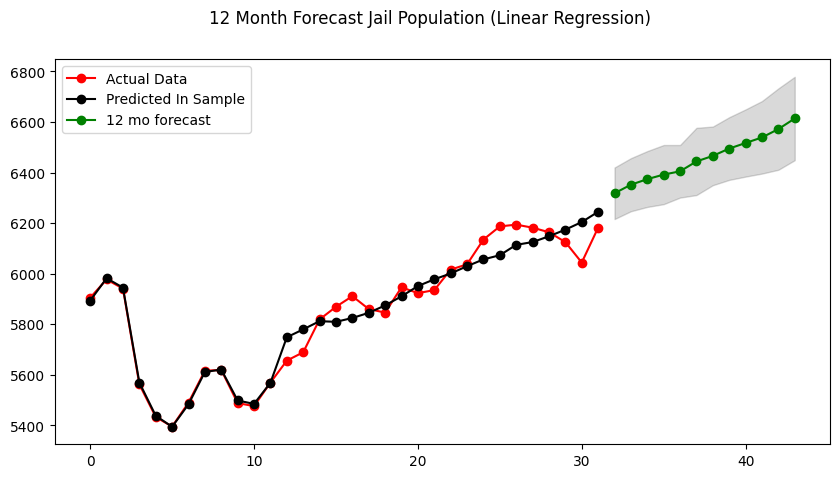

In [43]:
#plot actual data and forecast
#turn IS predicts into a dataframe with column names
IS_predicted_counts = pd.DataFrame(data = IS_inputs, columns = data.columns.to_list()[2:])
fc_12mo = forecast_data['ADP']

fig = plt.figure(figsize = (10,5))
fig.suptitle(f'12 Month Forecast Jail Population (Linear Regression)')
actual, = plt.plot(data.index,data.ADP, 'ro-', label='Actual Data')
predicted_IS, = plt.plot(IS_predicted_counts.index, IS_predicted_counts['ADP'], 'ko-', label='Predicted In Sample')
fc, = plt.plot(range(len(IS_inputs),len(IS_inputs)+len(fc_12mo)), fc_12mo, 'go-', label='12 mo forecast')
plt.fill_between(range(len(IS_inputs),len(IS_inputs)+len(fc_12mo)), forecast_data['lower_bound'], forecast_data['upper_bound'], color='k', alpha=.15) # conf

plt.legend(handles=[actual,predicted_IS,fc])
plt.show()

In [44]:
print(fc_12mo.mean(), fc_12mo.std())

6457.333333333333 92.46850405637717
